In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss

In [47]:
# Import the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
greeks = pd.read_csv('greeks.csv')

In [48]:
# Change to dummy variables
train['EJ'] = train['EJ'].apply(lambda x: 0 if x == 'A' else 1)
test['EJ'] = test['EJ'].apply(lambda x: 0 if x == 'A' else 1)

#Separating train data for predictors and response
X_train = train.drop('Class', axis = 1)
y_train = train.loc[:, 'Class']

#Dropping id column
X_train = X_train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

#Creating validation data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, stratify = y_train)

#Scaling the train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)
X_val_scaled = scaler.transform(X_val)
X_train = pd.DataFrame(X_train_scaled)
X_test = pd.DataFrame(X_test_scaled)
X_val = pd.DataFrame(X_val_scaled)

In [61]:
#Using for loop to iterate over potential values of n_neighbors for imputing missing values, using a 
#CatBoostRegressor() to get train MSE as the parameter to choose best value
scores = []
val_scores = []
for i in range(1, 15):
    imputer = KNNImputer(n_neighbors = i)
    X_train_imputed = imputer.fit_transform(X_train)
    model_test = CatBoostClassifier(verbose = False)
    model_test.fit(X_train_imputed, y_train)

    true_labels = np.array(y_train)
    predicted_probs = np.array(model_test.predict_proba(X_train_imputed))

    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    scores.append(balanced_logloss)
    true_labels = np.array(y_val)
    predicted_probs = np.array(model_test.predict_proba(X_val))

    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    
    val_scores.append(balanced_logloss)

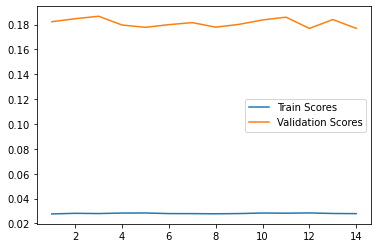

In [63]:
x = range(1, len(scores) + 1)
plt.plot(x, scores, label = 'Train Scores')
plt.plot(x, val_scores, label = 'Validation Scores')
plt.legend()

In [9]:
# Initial data analysis
print(train.isnull().sum())

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64
